# Financial Sentiment Analysis with Pretrained Models

## Importing Dependencies

In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import sys
import random

# NLP & Transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel

# Beautiful Soup
import re
from bs4 import BeautifulSoup

# NLTK for Text Preprocessing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, precision_score
from sklearn.preprocessing import LabelEncoder

# Keras & TensorFlow
import torch
import tensorflow as tf
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, LayerNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vvyas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vvyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vvyas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Downloading and Importing the Dataset

In [2]:
kaggle_api = KaggleApi()
kaggle_api.authenticate()

### Downloading Dataset

In [3]:
kaggle_api.dataset_download_files("ankurzing/sentiment-analysis-for-financial-news", path="./", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news


In [4]:
df = pd.read_csv('../Financial_news_Sentiment_Analysis/all-data.csv', header=None, encoding='latin')
df.columns = ['sentiment', 'text']

In [5]:
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


## Data Exploration

In [6]:
df.shape

(4846, 2)

In [7]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(6)

In [9]:
df = df.drop_duplicates()

In [10]:
df.shape

(4840, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4840 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4840 non-null   object
 1   text       4840 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


In [12]:
df['sentiment'].value_counts()

sentiment
neutral     2873
positive    1363
negative     604
Name: count, dtype: int64

C:\Users\vvyas\AppData\Local\Temp\ipykernel_17188\3738582660.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], palette='viridis')


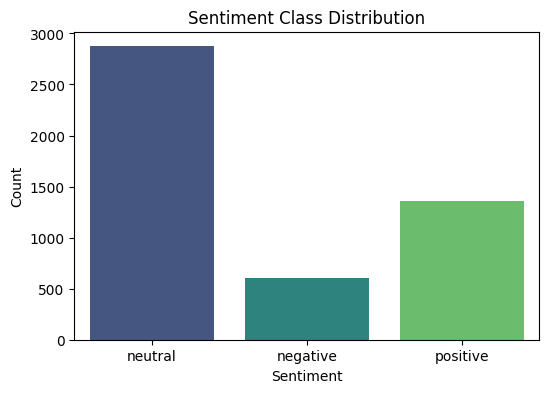

In [13]:
# Classes distribution in the Dataset

plt.figure(figsize=(6,4))
sns.countplot(x=df['sentiment'], palette='viridis')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [14]:
# Worcloud Visualization

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

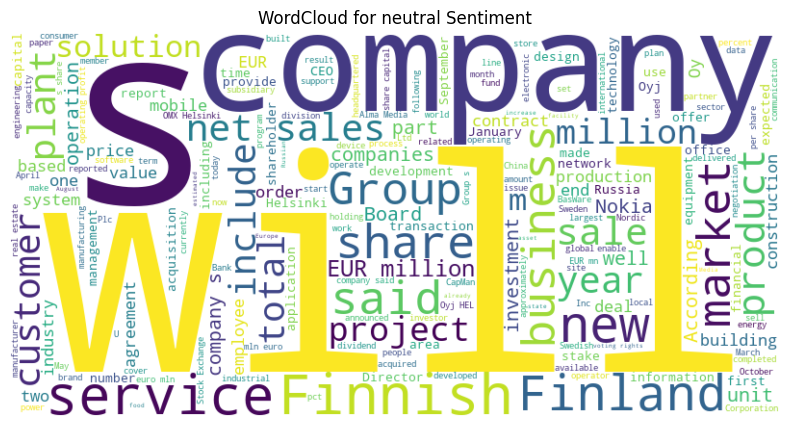

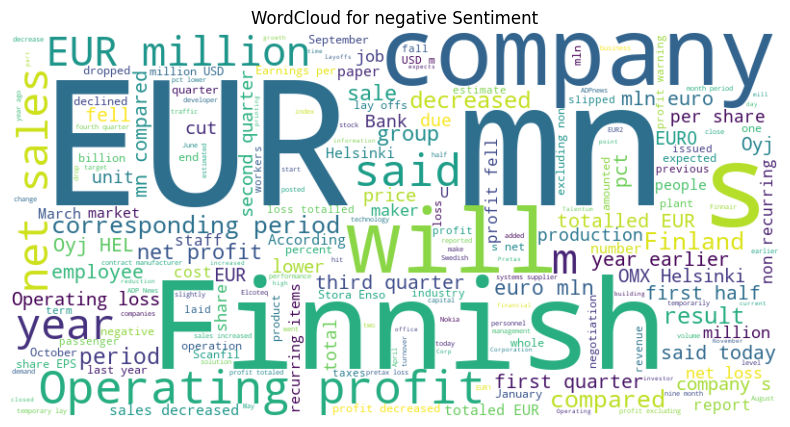

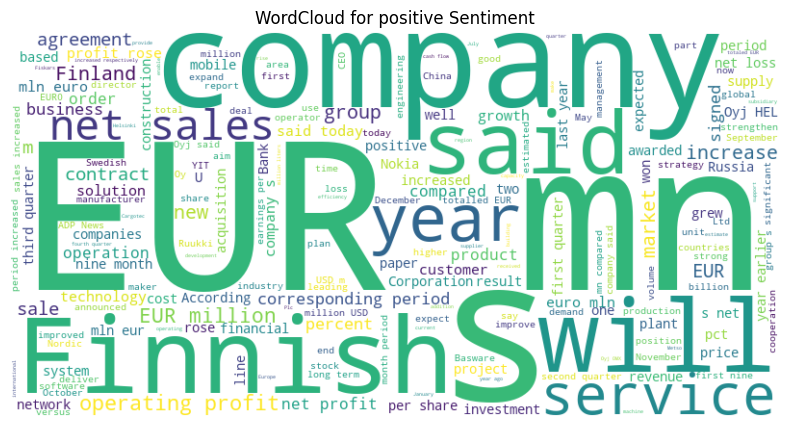

In [15]:
for sentiment in df['sentiment'].unique():
    plot_wordcloud(df[df['sentiment'] == sentiment]['text'], f"WordCloud for {sentiment} Sentiment")
    # sys.exit()

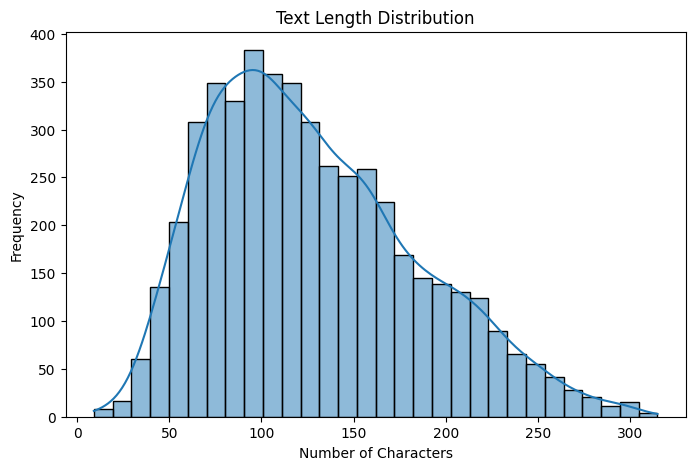

In [16]:
# Overall comparision of Text Lengths

df['num_words'] = df['text'].apply(len)
plt.figure(figsize=(8,5))
sns.histplot(df['num_words'], kde=True, bins=30)
plt.title("Text Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

- **Visual Representation**: The graph likely uses a bar chart or histogram to show the frequency of different text lengths, aiding in quick pattern recognition.
- **Frequency Range**: The y-axis ranges from 0 to 250, indicating a wide variability in text lengths within the "Minutes of Chameleon" dataset.
- **Contextual Insight**: The distribution helps understand the consistency and detail of meeting minutes or documentation, useful for quality control and process improvement.

In [17]:
df['num_words'].describe()

count    4840.000000
mean      128.076446
std        56.416479
min         9.000000
25%        84.000000
50%       119.000000
75%       163.000000
max       315.000000
Name: num_words, dtype: float64

## Data Preprocessing

In [18]:
df

,sentiment,text,num_words
0,neutral,"According to Gran , the company has no plans t...",127
1,neutral,Technopolis plans to develop in stages an area...,190
2,negative,The international electronic industry company ...,228
3,positive,With the new production plant the company woul...,206
4,positive,According to the company 's updated strategy f...,203
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,144
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,148
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,108
4844,negative,Net sales of the Paper segment decreased to EU...,226


### Text Preprocessing

In [19]:
def text_preprocess(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters & digits
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

**Text Preprocessing Function**

The `preprocess_text` function cleans and prepares raw text for NLP tasks. It performs the following steps:

1. **Remove HTML Tags**: Uses `BeautifulSoup` to strip HTML markup.
2. **Remove URLs**: Eliminates web links using regex.
3. **Remove Special Characters & Digits**: Keeps only alphabetic characters and spaces.
4. **Convert to Lowercase**: Ensures uniformity in text.
5. **Remove Stopwords**: Filters out common stopwords (e.g., "the", "is") to focus on meaningful words.

**Input**: Raw text (may include HTML, URLs, etc.).  
**Output**: Cleaned, lowercase text without stopwords.

In [20]:
# # Apply Text Preprocessing
# df['text'] = df['text'].apply(text_preprocess)

### Data Augmentation

In [21]:
# Getting Synonyms using WordNet

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

In [22]:
# Synonym Replacement for Data Augmentation

def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    np.random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if synonyms:
            synonym = np.random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

In [23]:
# Apply Synonym Replacement for Data Augmentation

df_augmented = df.copy()
df_augmented['text'] = df_augmented['text'].apply(lambda x: synonym_replacement(text_preprocess(x)))
df = pd.concat([df, df_augmented])

C:\Users\vvyas\AppData\Local\Temp\ipykernel_17188\2372336981.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


## Encoding

In [24]:
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])

## Train-Test Split

In [25]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'], shuffle=True)

In [26]:
train_df

,sentiment,text,num_words
578,1,"Helsinki on October 22 , 2008 SSH COMMUNICATIO...",217
2348,1,He will report to CapMan Plc 's CEO Heikki Wes...,55
1992,2,markets have a bun in the oven poor performanc...,156
1656,1,"The study evaluated the safety , tolerability ...",169
4647,0,26 October 2010 - Finnish environmental manage...,244
...,...,...,...
2777,1,"After the transaction , M-real will own 30 % i...",78
430,1,german commerzbank atomic number 47 hamburg br...,145
2526,1,price details let on,35
2003,2,accord pkc acquisition would fetch significant...,95


In [27]:
val_df

,sentiment,text,num_words
3377,1,total restructure costs bear eur mn eur mn boo...,116
2374,0,suomi plumbing heating system systems supplier...,145
1219,1,financialwire atomic number 69 cooperation inv...,254
1936,2,We aim to ensure that Vacon is in good shape w...,148
1457,1,completed m watchtower highest work up ireland,83
...,...,...,...
280,2,Sanoma Magazines Finland 's net sales grew to ...,78
1782,2,hk ruokatalo write up fowl sales finland profi...,109
4494,1,board suppose company omitted tender substanti...,171
3803,1,company transportation business conducted suns...,217


## Downloading the Pre Trained Tokenizer & Model

### Teacher Model: FinBERT Model

In [28]:
# Load Pretrained Teacher Model & Tokenizer

teacher_model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = TFAutoModelForSequenceClassification.from_pretrained(teacher_model_name, num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
teacher_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Student Model: DistilBERT Model

In [30]:
# Load Student Model

student_model_name = "distilbert-base-uncased"
student_model = TFAutoModel.from_pretrained(student_model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [31]:
student_model.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tokenization

In [32]:
X_train = tokenizer(train_df['text'].tolist(), max_length=64, padding=True, truncation=True, return_tensors="tf")
X_val = tokenizer(val_df['text'].tolist(), max_length=64, padding=True, truncation=True, return_tensors="tf")
y_train, y_val = train_df['sentiment'], val_df['sentiment']

## Defining Custom BERT Model

In [33]:
class CustomBERTModel(tf.keras.Model):
    def __init__(self, student_model):
        super(CustomBERTModel, self).__init__()
        self.bert = student_model.distilbert
        self.norm = LayerNormalization()
        self.pooling = GlobalAveragePooling1D()
        self.dense1 = Dense(256, activation='relu')
        self.dropout1 = Dropout(0.3)
        self.dense2 = Dense(128, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.dense3 = Dense(64, activation='relu')
        self.dropout3 = Dropout(0.1)
        self.output_layer = Dense(3, activation='softmax')
    
    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state   # Extract last hidden state
        x = self.norm(x)
        x = self.pooling(x)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.dropout3(x)
        return self.output_layer(x)

### Unfreezing the top BERT layers

In [34]:
for layer in teacher_model.bert.encoder.layer[:-3]:
    layer.trainable = False  # Freeze all but the last two layers

In [35]:
teacher_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 45693699 (174.31 MB)
Non-trainable params: 63790848 (243.34 MB)
_________________________________________________________________


### Model Initialization

In [36]:
student_model = CustomBERTModel(student_model)

## Defining Loss

In [37]:
def distillation_loss(y_true, y_pred, y_teacher, alpha=0.5, temperature=3.0):
    y_pred_soft = tf.nn.softmax(y_pred / temperature)
    y_teacher_soft = tf.nn.softmax(y_teacher / temperature)
    kl_loss = tf.keras.losses.KLDivergence()(y_teacher_soft, y_pred_soft)
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    return alpha * kl_loss + (1 - alpha) * ce_loss

## Compiling the Model

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

student_model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_model({'input_ids': tf.cast(y_true, tf.int32), 'attention_mask': tf.ones_like(y_true, dtype=tf.int32)})[0]), metrics=['accuracy'])

## Training the Model

### Defining Callbacks

In [39]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=2),
    ModelCheckpoint(filepath='distilled_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2)
]

### Training

In [40]:
# Ensuring input tensors are of correct dtype

X_train = {key: tf.cast(value, dtype=tf.int32) for key, value in X_train.items()}
X_val = {key: tf.cast(value, dtype=tf.int32) for key, value in X_val.items()}

In [41]:
history = student_model.fit(
    x={"input_ids": X_train['input_ids'], "attention_mask": X_train['attention_mask']},
    y=y_train,
    validation_data=({"input_ids": X_val['input_ids'], "attention_mask": X_val['attention_mask']}, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5033 - loss: 0.5116  
Epoch 1: val_accuracy improved from -inf to 0.68079, saving model to distilled_model.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.5037 - loss: 0.5113 - val_accuracy: 0.6808 - val_loss: 0.3620 - learning_rate: 5.0000e-05
Epoch 2/20


C:\Users\vvyas\.conda\envs\bert\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: student_model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_model({'input_ids': tf.cast(y_true, tf.int32), 'attention_mask': tf.ones_like(y_true, dtype=tf.int32)})[0]), metrics=['accuracy'])

  return {key: serialize_keras_object(value) for key, value in obj.items()}


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7108 - loss: 0.3444  
Epoch 2: val_accuracy improved from 0.68079 to 0.73502, saving model to distilled_model.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.7108 - loss: 0.3443 - val_accuracy: 0.7350 - val_loss: 0.3150 - learning_rate: 5.0000e-05
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7489 - loss: 0.2978  
Epoch 3: val_accuracy improved from 0.73502 to 0.74742, saving model to distilled_model.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.7489 - loss: 0.2978 - val_accuracy: 0.7474 - val_loss: 0.2950 - learning_rate: 5.0000e-05
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7623 - loss: 0.2805  
Epoch 4: val_accuracy did not improve from 0.74742
242/242 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.7623 - loss: 0.2805 - val_accuracy: 0.7459 - val_loss: 0.2874 - learning_rate: 5.0000e-05
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7755 - l

## Visualization of Training History

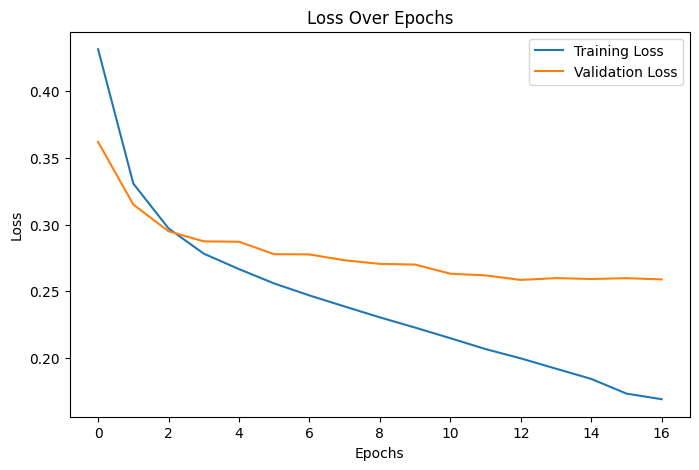

In [42]:
# Plotting Training History

plt.figure(figsize=(8 ,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

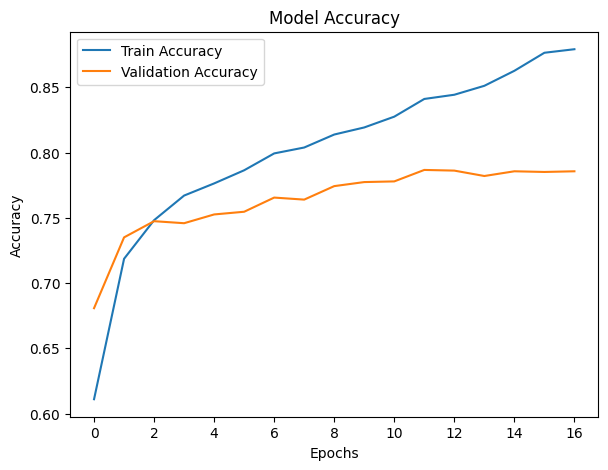

In [43]:
plt.figure(figsize=(15 ,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluating the Model

In [44]:
# Evaluate Model

y_pred = np.argmax(student_model.predict({"input_ids": X_val['input_ids'], "attention_mask": X_val['attention_mask']}), axis=1)
print("Classification Report:\n", classification_report(y_val, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step   
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.72      0.69       242
           1       0.83      0.89      0.86      1149
           2       0.74      0.60      0.67       545

    accuracy                           0.79      1936
   macro avg       0.75      0.74      0.74      1936
weighted avg       0.78      0.79      0.78      1936



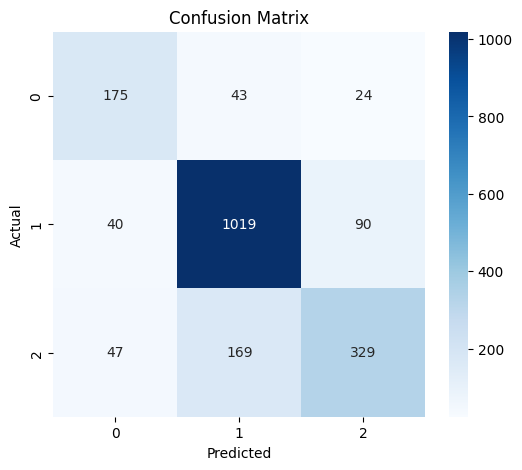

In [45]:
# Confusion Matrix Visualization
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Predicting using the Trained Model

In [46]:
def predict_sentiment(text, model, tokenizer, encoder):
    processed_text = text_preprocess(text)
    tokens = tokenizer([processed_text], max_length=64, padding=True, truncation=True, return_tensors="tf")
    predictions = model.predict({"input_ids": tokens['input_ids'], "attention_mask": tokens['attention_mask']})
    predicted_label = np.argmax(predictions, axis=1)
    return encoder.inverse_transform(predicted_label)[0]

In [47]:
sample_texts = [
    "Investors lost confidence due to poor financial management.",  # Negative
    "The company reported a significant drop in quarterly earnings.",  # Negative
    "The stock market closed with mixed results this afternoon.",  # Neutral
    "The central bank maintained current interest rates this month.",  # Neutral  
    "Stock prices surged after the positive market outlook.", # Positive
    "The central bank announced a favorable economic growth forecast."  # Positive
]

random.shuffle(sample_texts)

for text in sample_texts:
    print(f"Text: {text}\nPredicted Sentiment: {predict_sentiment(text, student_model, tokenizer, encoder)}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Text: The central bank announced a favorable economic growth forecast.
Predicted Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Text: Stock prices surged after the positive market outlook.
Predicted Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Text: The central bank maintained current interest rates this month.
Predicted Sentiment: neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Text: Investors lost confidence due to poor financial management.
Predicted Sentiment: negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Text: The stock market closed with mixed results this afternoon.
Predicted Sentiment: negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Text: The company reported a significant drop in quarterly earnings.
Predicted Sentiment: negative

